### KPI Selection and Filtering

1. **Notebook Objective:**
	- This notebook will collect KPIs selected by the user for stocks identified from the Sharpe Ratio calculations
	- It will filter out stocks that underperform the SPY based on their Sharpe Ratio
	- The user can choose which KPIs to analyze
	- The notebook will then filter stocks based on whether their KPIs are above or below the sector median, according to user-defined criteria
	- It will also allow the user to plot the distribution of selected KPIs to identify trends or commonalities


In [1]:
import time
import os 

start_time = time.time() # measuring run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')

from utils.helpers import divide_chunks

import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, List, Optional
import pandas as pd
from tenacity import retry, stop_after_attempt, wait_exponential
from tqdm import tqdm
from functools import lru_cache
import yfinance as yf

Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py

---------------------------------
helpers.py successfully loaded, updated last Feb. 04 2025
---------------------------------




Set up logging and batch processing to prevent rate limits or data request rejections.

In [2]:
# Setup logging, and batching to avoid kickbacks

logging.basicConfig(level=logging.INFO)

@lru_cache(maxsize=1000)
def fetch_ticker_info_cached(ticker_symbol: str) -> Dict[str, Optional[float]]:
    """
    Cached retrieval of ticker info from Yahoo Finance to minimize repeated API calls.
    """
    try:
        return yf.Ticker(ticker_symbol).info
    except Exception as e:
        logging.error(f"Error fetching data for {ticker_symbol}: {e}")
        return {}

@retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=4, max=10)
)

def fetch_with_retry(ticker: str) -> Dict[str, Optional[float]]:
    """
    Retry fetching data for a ticker symbol using tenacity.
    """
    return fetch_ticker_info_cached(ticker)

def get_stock_kpis(ticker: str, kpis: List[str]) -> Dict[str, Optional[float]]:
    """
    Fetch KPIs for a specific stock ticker.
    """
    try:
        info = fetch_with_retry(ticker)
        kpi_data = {kpi: info.get(kpi) for kpi in kpis}
        kpi_data['Tickers'] = ticker  # Add ticker column
        return kpi_data
    except Exception as e:
        logging.error(f"Error processing {ticker}: {e}")
        return {'Tickers': ticker, **{kpi: None for kpi in kpis}}


def batch_process_stocks(tickers: List[str], kpis: List[str], max_workers: int = 10) -> pd.DataFrame:
    """
    Process stock tickers in batches using ThreadPoolExecutor for parallel API calls.
    """
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_ticker = {
            executor.submit(get_stock_kpis, ticker, kpis): ticker
            for ticker in tickers
        }

        for future in tqdm(as_completed(future_to_ticker), total=len(tickers)):
            results.append(future.result())

    # Create DataFrame from results
    df = pd.DataFrame(results)
    return df


In [3]:
# Find Benchmark Sharpe
sharpe_df = pd.read_csv(f'{WORKSPACE_DIR}/portfolio_py/data/clean/sharpe_ratios.csv')


In [4]:
# Fetch KPI's

num_in_chunks = 20
tickers = sharpe_df['Tickers'].tolist()

print('\n----Intiating Chunk Process----')
ticker_chunks = list(divide_chunks(tickers, num_in_chunks))
print(f'{len(tickers)} tikcers divided into {len(ticker_chunks)} chunks')
        
essential_kpis = ['marketCap', 'trailingPE', 'forwardPE', 
                  'profitMargins', 'trailingEps', 'quickRatio',
                  'earningsQuarterlyGrowth'
                ]

df_list = []

# Loop through each chunk and process the stocks
print('\n----Fethcing KPIs----')
for chunk in ticker_chunks:
    kpi_df_chunk = batch_process_stocks(chunk, essential_kpis)
    df_list.append(kpi_df_chunk)

# Concatenate all DataFrames vertically
kpi_df = pd.concat(df_list, axis=0, ignore_index=True).dropna()
print(f'KPI Df Shape: {kpi_df.shape}')


----Intiating Chunk Process----
3370 tikcers divided into 169 chunks

----Fethcing KPIs----


 30%|███       | 6/20 [00:01<00:02,  5.89it/s]ERROR:root:Error fetching data for CASY: HTTP Error 401: 
ERROR:root:Error fetching data for DUOL: HTTP Error 401: 
ERROR:root:Error fetching data for DPZ: HTTP Error 401: 
 45%|████▌     | 9/20 [00:02<00:02,  4.72it/s]ERROR:root:Error fetching data for FFIV: HTTP Error 401: 
ERROR:root:Error fetching data for CYBR: HTTP Error 401: 
 55%|█████▌    | 11/20 [00:03<00:02,  3.50it/s]ERROR:root:Error fetching data for FNF: HTTP Error 401: 
ERROR:root:Error fetching data for OC: HTTP Error 401: 
 70%|███████   | 14/20 [00:03<00:01,  3.62it/s]ERROR:root:Error fetching data for MBLY: HTTP Error 401: 
ERROR:root:Error fetching data for AVTR: HTTP Error 401: 
ERROR:root:Error fetching data for LNT: HTTP Error 401: 
ERROR:root:Error fetching data for BAX: HTTP Error 401: 
ERROR:root:Error fetching data for BEP: HTTP Error 401: 
  5%|▌         | 1/20 [00:01<00:27,  1.44s/it]ERROR:root:Error fetching data for DLTR: HTTP Error 401: 
ERROR:root:Error fetc

KeyboardInterrupt: 

/var/folders/cd/2yq8cm193ln9jmnq_z6wtxnw0000gn/T/ipykernel_7605/2658041121.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kpi_df = kpi_df.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN


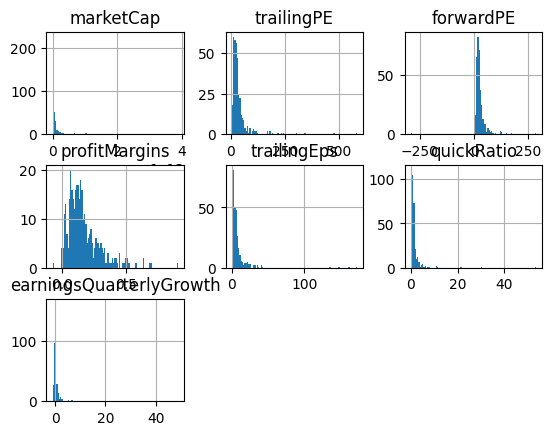

In [ ]:
import numpy as np

# Minor data cleaning
kpi_df = kpi_df.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
kpi_df['trailingPE'] = kpi_df['trailingPE'].astype(float)
kpi_df.select_dtypes(include=['number']).hist(bins=100) # to view distribution

valuation_df = pd.merge(kpi_df, sharpe_df, on='Tickers').dropna()
median_values = valuation_df.describe().loc['50%'].to_dict() # Use median as the data often does not follow normal distrubution

# Get sectors
sector_dict = {} #ticker: sector
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=2, min=1, max=32))
def fetch_sector(ticker):
    return yf.Ticker(ticker).info.get('sector')

for chunk in ticker_chunks:
    for ticker in chunk:
        try:
            sector_dict[ticker] = fetch_sector(ticker)
        except Exception as e:
            print(f"Failed to fetch {ticker} after retries: {e}")

sector_df = pd.DataFrame(list(sector_dict.items()), columns=['Tickers', 'Sector'])
valuation_df = pd.merge(left=sector_df, right=valuation_df, right_on='Tickers', left_on='Tickers')

In [ ]:
# used to view distrubution, how ever is fixed, and user will need to change

# print(kpi_df['earningsQuarterlyGrowth'].median())
# kpi_df['earningsQuarterlyGrowth'].hist(bins=100) # to view distribution

In [ ]:
#filtering

grouped = valuation_df.groupby(['Sector']).median(numeric_only=True)

merged_df = pd.merge(valuation_df, grouped, on='Sector', suffixes=('_stock', '_sector'))

merged_df = merged_df[merged_df['Sharpe_ratios_stock'] >= merged_df['Sharpe_ratios_sector']] # above median sharpe, this is a performance measure
merged_df = merged_df[merged_df['profitMargins_stock'] >= merged_df['profitMargins_sector']] # above median prof margin, this is a performance measure
merged_df = merged_df[merged_df['trailingPE_stock'] <= merged_df['trailingPE_sector']] # below median trailing pe ratio, this is a risk adverse measure; sharpe ratio does not take into account over valuation
merged_df = merged_df[merged_df['quickRatio_stock'] >= merged_df['quickRatio_sector']] # above median quick ratio, this is a risk adverse measure; sharpe ratio does not take into account over leveraged
merged_df = merged_df[merged_df['earningsQuarterlyGrowth_stock'] >= 0]

stock_cols_only = [col for col in merged_df.columns if '_sector' not in col]
filtered_valuation_df = merged_df[stock_cols_only] # export only stock info, no need for sector info

filtered_valuation_df.columns = filtered_valuation_df.columns.str.replace('_stock', '', regex=False) # clean up excesive stock col name


filtered_valuation_df.to_csv(f'{WORKSPACE_DIR}/portfolio_py/data/clean/filtered_valuation_df.csv', index=False)
logging.info(f"Final filtered DataFrame saved. Rows: {filtered_valuation_df.shape[0]}")

# Print the sorted DataFrame (Optional)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'\nTotal Run Time: {elapsed_time} seconds')
filtered_valuation_df.reset_index(drop=True)

INFO:root:Final filtered DataFrame saved. Rows: 16



Total Run Time: 212.75740504264832 seconds


,Tickers,Sector,marketCap,trailingPE,forwardPE,profitMargins,trailingEps,quickRatio,earningsQuarterlyGrowth,Sharpe_ratios,Date_Collected
0,BABA,Consumer Cyclical,2.593549e+11,14.532085,11.013171,0.13059,7.48,1.158,2.732,1.256170,2025-06-15
1,MMM,Industrials,8.230940e+10,19.046078,19.359493,0.17791,8.03,1.114,0.203,1.297640,2025-06-15
2,MPLX,Energy,5.210163e+10,11.787529,11.573697,0.38998,4.33,1.027,0.120,1.503437,2025-06-15
3,GRMN,Technology,4.135203e+10,28.333775,28.789545,0.22762,7.58,2.615,0.206,0.901269,2025-06-15
4,ANYYY,Industrials,4.017885e+10,16.910257,8.912162,0.33547,0.78,1.218,0.154,1.266057,2025-07-04
5,EBAY,Consumer Cyclical,3.519005e+10,18.355770,14.628353,0.19783,4.16,1.072,0.148,1.002590,2025-07-04
6,CHKP,Technology,2.423456e+10,29.502640,22.497990,0.32746,7.58,1.043,0.038,1.234018,2025-07-04
7,TPR,Consumer Cyclical,1.873364e+10,23.736841,18.949577,0.12497,3.80,0.976,0.458,1.275293,2025-07-04
8,AU,Basic Materials,2.354642e+10,15.214984,16.985455,0.21093,3.07,1.359,6.638,1.510958,2025-07-04
9,KGC,Basic Materials,1.945705e+10,16.183672,18.022726,0.21740,0.98,1.146,2.439,2.088090,2025-07-04
